# Multilayer Perceptron using Minibatch SGD on CIFAR 10 Dataset

The CIFAR 10 dataset contains 60000 32x32 colour images (i.e. 3 channels), 50000 of which are training images and 10000 test images. 

There are 10 classes of images: 
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. There are 6000 images per class. 

The dataset has 5 training batches and one test batch. The test batach has 1000 randomly selected images for each class. The training batches may contain more images from one class than another. 


https://zhenye-na.github.io/2018/09/28/pytorch-cnn-cifar10.html

In [ ]:
class Layer:
#A building block. Each layer is capable of performing two things:
#- Process input to get output: output = layer.forward(input)
#- Propagate gradients through itself: grad_input = layer.backward(input, grad_output)
#Some layers also have learnable parameters which they update during layer.backward.

  def __init__(self):
      # Here we can initialize layer parameters (if any) and auxiliary stuff.
      # A dummy layer does nothing
      pass

  def forward(self, input):
      # Takes input data of shape [batch, input_units], returns output data [batch, output_units]
      # A dummy layer just returns whatever it gets as input.
      return input

  def backward(self, input, grad_output):
      # Performs a backpropagation step through the layer, with respect to the given input.
      # To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
      # d loss / d x  = (d loss / d layer) * (d layer / d x)
      # Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
      # If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
      # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
      
      num_units = input.shape[1]
      
      d_layer_d_input = np.eye(num_units)
      
      return np.dot(grad_output, d_layer_d_input) # chain rule

In [ ]:
import numpy as np
from keras.utils.np_utils import to_categorical   
np.random.seed(42)


class Dense():

  def __init__(self, n_inputs, n_outputs, lr=0.1):
    self.lr = lr

    # Randomly initialize weights with uniform distribution
    self.weights = np.random.uniform(-1/np.sqrt(n_inputs), 1/np.sqrt(n_inputs),[n_inputs, n_outputs])
    self.biases = np.zeros(n_outputs)

  def forward(self, input): 
    # Will do f(x) = weights*inputs + b
    # input shape: [batch, input_units]
    # output shape: [batch, output units]
    
    return np.dot(input,self.weights) + self.biases

  def backward(self, input, grad_output):
    # Performs a backpropagation step through the layer, with respect to the given input.
    # To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
    # compute d f / d x = d f / d layer * d layer / d x
    # where d layer/ d x = weights transposed

    grad_input = np.dot(grad_output, self.weights.T)

    # compute gradient w.r.t. weights and biases
    grad_weights = np.dot(input.T, grad_output)
    grad_biases = grad_output.mean(axis=0)*input.shape[0]

    # Stochastic gradient descent step to update weights
    self.weights = self.weights - self.lr * grad_weights
    self.biases = self.biases - self.lr * grad_biases
    
    return grad_input

class ReLU():
    def __init__(self):
        # ReLU layer simply applies elementwise rectified linear unit to all inputs
        pass
    
    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        return grad_output*relu_grad

In [ ]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

## Load the Data

In [ ]:
import numpy as np
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical   

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)
X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = X_train.astype('float')
X_test = X_test.astype('float')

# Normalization of pixel values (to [0-1] range)
X_train /= 255
X_test /= 255

### Display some data 

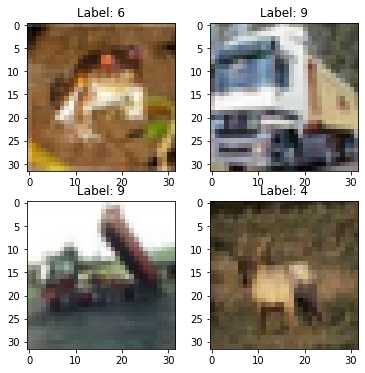

In [ ]:
import matplotlib.pyplot as plt

## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([32,32,3]));

### Create the model

In [ ]:
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

### Minibatch 

In [ ]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

### Train the model 

Epoch 1
Train accuracy: 0.1
Val accuracy: 0.1


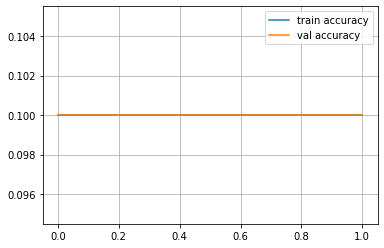

 18%|█▊        | 279/1562 [00:03<00:17, 73.23it/s]


KeyboardInterrupt: ignored

In [ ]:
from IPython.display import clear_output

train_log = []
val_log = []

for epoch in range(25):

  # Create the network (2 layers)
  mlp = []
  mlp.append(Dense(X_train.shape[1],256))
  mlp.append(ReLU())
  mlp.append(Dense(256,10))
  
  for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
      train(mlp,x_batch,y_batch)
  
  train_log.append(np.mean(predict(mlp,X_train)==y_train))
  val_log.append(np.mean(predict(mlp,X_test)==y_test))
  
  clear_output()
  print("Epoch",epoch)
  print("Train accuracy:",train_log[-1])
  print("Val accuracy:",val_log[-1])
  plt.plot(train_log,label='train accuracy')
  plt.plot(val_log,label='val accuracy')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

In [ ]:
print(mlp[0].weights)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
